In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from autogluon.tabular import TabularPredictor

In [3]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')

In [4]:
df_train.head()

,ID,추석까지 남은 기간(주),쇼핑몰 구분,가격(원),프로모션 여부,도시 유형,지역 유형,쇼핑몰 유형,선물 유형,수요량
0,TRAIN_0000,1,쇼핑몰 15,212000,0,도시 6,지역 1,쇼핑몰 유형 2,명절혼합과일선물세트,28
1,TRAIN_0001,2,쇼핑몰 72,113000,0,도시 21,지역 1,쇼핑몰 유형 1,발효홍삼선물세트,27
2,TRAIN_0002,0,쇼핑몰 15,67000,0,도시 6,지역 1,쇼핑몰 유형 2,실속스팸선물세트,769
3,TRAIN_0003,1,쇼핑몰 13,206000,0,도시 12,지역 3,쇼핑몰 유형 1,자연산프리미엄버섯선물세트,27
4,TRAIN_0004,1,쇼핑몰 65,140000,0,도시 16,지역 2,쇼핑몰 유형 2,자연산새우선물세트,337


## 0.  EDA

데이터요약

In [18]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5872 entries, 0 to 5871
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ID             5872 non-null   object
 1   추석까지 남은 기간(주)  5872 non-null   int64 
 2   쇼핑몰 구분         5872 non-null   object
 3   가격(원)          5872 non-null   int64 
 4   프로모션 여부        5872 non-null   int64 
 5   도시 유형          5872 non-null   object
 6   지역 유형          5872 non-null   object
 7   쇼핑몰 유형         5872 non-null   object
 8   선물 유형          5872 non-null   object
 9   수요량            5872 non-null   int64 
dtypes: int64(4), object(6)
memory usage: 458.9+ KB


In [7]:
# 기술통계량 확인
df_train.describe()

,추석까지 남은 기간(주),가격(원),프로모션 여부,수요량
count,5872.000000,5872.000000,5872.000000,5872.000000
mean,0.983311,157896.287466,0.085320,264.313692
std,0.814237,75806.989671,0.279381,338.789214
min,0.000000,38000.000000,0.000000,13.000000
25%,0.000000,112000.000000,0.000000,54.000000
50%,1.000000,139000.000000,0.000000,136.000000
75%,2.000000,212000.000000,0.000000,350.000000
max,2.000000,340000.000000,1.000000,4455.000000


In [19]:
df_train.isnull().sum() # 결측치 없음

ID               0
추석까지 남은 기간(주)    0
쇼핑몰 구분           0
가격(원)            0
프로모션 여부          0
도시 유형            0
지역 유형            0
쇼핑몰 유형           0
선물 유형            0
수요량              0
dtype: int64

In [20]:
df_train[df_train.duplicated()] # 중복값 없음

,ID,추석까지 남은 기간(주),쇼핑몰 구분,가격(원),프로모션 여부,도시 유형,지역 유형,쇼핑몰 유형,선물 유형,수요량


Visualization(시각화)

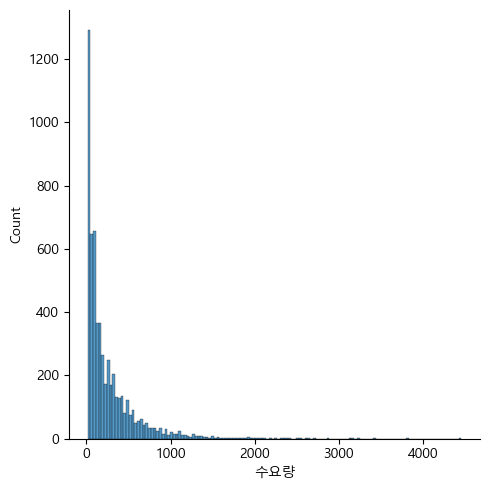

In [14]:
import warnings
# 경고창 숨기기
warnings.filterwarnings('ignore') 

#그래프 한글깨짐 해결 
plt.rcParams['font.family'] = 'Malgun Gothic'

# 종속변수에 대한 분포를 확인
sns.displot(df_train['수요량'])
plt.show()

# 로그변환 필요


<Axes: xlabel='추석까지 남은 기간(주)', ylabel='수요량'>

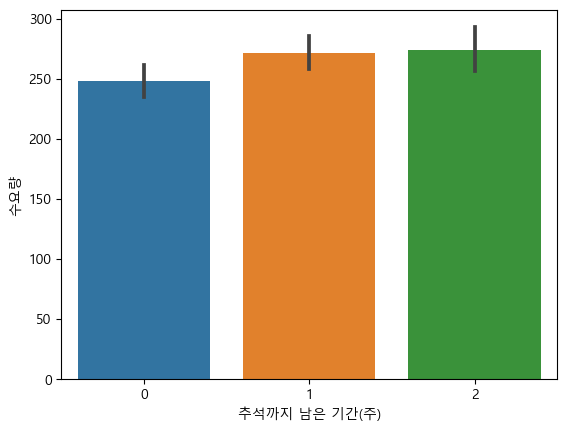

In [15]:
# 추석까지 남은 기간에 따른 수요량 평균 시각화
sns.barplot(x=df_train['추석까지 남은 기간(주)'], y=df_train['수요량'])

<Axes: xlabel='지역 유형'>

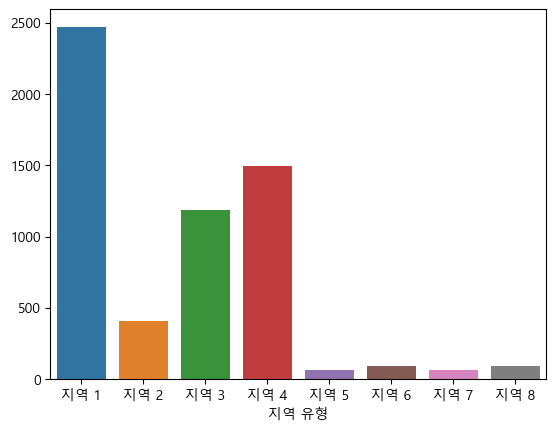

In [20]:
# 지역별 수요량 평균 확인
region_category = df_train['지역 유형'].value_counts().sort_index()
# region_category
sns.barplot(x=region_category.index, y=region_category.values)

이상치 확인

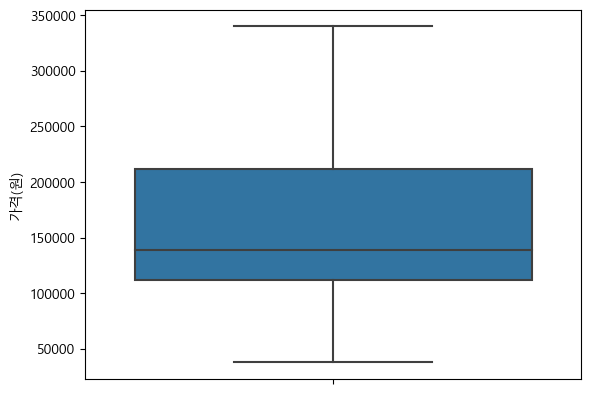

In [24]:
sns.boxplot(y = df_train['가격(원)'])
plt.show()

<Axes: >

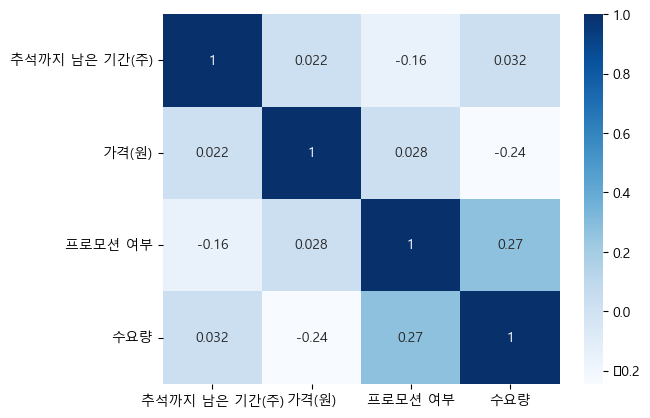

In [40]:
# 연속형 변수들의 상관계수 확인
cor = df_train[['추석까지 남은 기간(주)', '가격(원)','프로모션 여부','수요량']].corr()
sns.heatmap(cor, annot = True, cmap='Blues')
# sns.heatmap(df_train)


# 방법1) 레이블 인코딩 이용 
- 의사결정나무, 랜덤포레스트 : 숫자의 차이가 모델에 영향을 주지 않는 트리 계열 모델에 적용

## 01. 데이터 전처리

In [51]:
# 모델 적합성 검정을 위한 함수 
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error

def evaluate_reg_all(y_test, y_predict):
    MSE = mean_squared_error(y_test,y_predict,squared=True)
    RMSE = mean_squared_error(y_test,y_predict,squared=False)
    MAE = mean_absolute_error(y_test,y_predict)
    R2 = r2_score(y_test,y_predict)
    
    print(f'MSE: {MSE:.3f}, RMSE: {RMSE:.3F}, MAE: {MAE:.3F}, R^2: {R2:.3F}')

In [32]:
from sklearn.preprocessing import LabelEncoder

encoding_columns = ['쇼핑몰 구분', '도시 유형','지역 유형','쇼핑몰 유형','선물 유형']
not_encoding_columns = ['ID', '추석까지 남은 기간(주)', '가격(원)','프로모션 여부','수요량']


In [33]:
enc_classes = {} 
def encoding_label(x):   # x: 범주형 타입의 컬럼(Series)
    le = LabelEncoder()
    le.fit(x)
    label = le.transform(x)
    enc_classes[x.name] = le.classes_   # x.name: 컬럼명
    return label

In [36]:
d1 = df_train[encoding_columns].apply(encoding_label)
d1

,쇼핑몰 구분,도시 유형,지역 유형,쇼핑몰 유형,선물 유형
0,6,20,0,1,9
1,69,13,0,0,15
2,6,20,0,1,22
3,4,3,2,0,32
4,61,7,1,1,30
...,...,...,...,...,...
5867,40,7,2,0,5
5868,36,7,3,2,40
5869,37,19,3,0,11
5870,66,21,0,0,23


In [39]:
d2 = df_train[not_encoding_columns]
d2

,ID,추석까지 남은 기간(주),가격(원),프로모션 여부,수요량
0,TRAIN_0000,1,212000,0,28
1,TRAIN_0001,2,113000,0,27
2,TRAIN_0002,0,67000,0,769
3,TRAIN_0003,1,206000,0,27
4,TRAIN_0004,1,140000,0,337
...,...,...,...,...,...
5867,TRAIN_5867,2,225000,0,27
5868,TRAIN_5868,2,62000,0,40
5869,TRAIN_5869,2,131000,0,55
5870,TRAIN_5870,2,85000,0,231


In [41]:
df_train_encoding = d2.join(d1)
df_train_encoding

,ID,추석까지 남은 기간(주),가격(원),프로모션 여부,수요량,쇼핑몰 구분,도시 유형,지역 유형,쇼핑몰 유형,선물 유형
0,TRAIN_0000,1,212000,0,28,6,20,0,1,9
1,TRAIN_0001,2,113000,0,27,69,13,0,0,15
2,TRAIN_0002,0,67000,0,769,6,20,0,1,22
3,TRAIN_0003,1,206000,0,27,4,3,2,0,32
4,TRAIN_0004,1,140000,0,337,61,7,1,1,30
...,...,...,...,...,...,...,...,...,...,...
5867,TRAIN_5867,2,225000,0,27,40,7,2,0,5
5868,TRAIN_5868,2,62000,0,40,36,7,3,2,40
5869,TRAIN_5869,2,131000,0,55,37,19,3,0,11
5870,TRAIN_5870,2,85000,0,231,66,21,0,0,23


## 02. 데이터 분석

In [42]:
# 데이터 셋 분할 
from sklearn.model_selection import train_test_split

x_data = df_train_encoding.drop(['ID','수요량'], axis=1)
y_data = df_train_encoding['수요량']

x_train, x_valid, y_train, y_valid = train_test_split(x_data, y_data, test_size = 0.3)

의사결정나무

In [52]:
from sklearn.tree import DecisionTreeRegressor

# 모델생성
model = DecisionTreeRegressor() 

# 모델 학습 
model.fit(x_train, y_train)

# 모델검증
print(model.score(x_train, y_train))
print(model.score(x_valid, y_valid))

# 모델 예측
y_predict = model.predict(x_valid)

# 모델 평가척도
evaluate_reg_all(y_valid, y_predict)

1.0
0.4448364205457168
MSE: 64309.864, RMSE: 253.594, MAE: 134.307, R^2: 0.445


In [ ]:
# from sklearn.tree import export_graphviz

# export_graphviz(
#   model, # 시각화 할 모델
#   out_file="tree.dot", # 시각화 결과물을 저장할 파일 경로
#   class_names = ["수요량"], # 문자열로 된 클래스들의 이름
#   feature_names = ['추석까지 남은 기간(주)', '가격(원)','프로모션 여부','쇼핑몰 구분', '도시 유형','지역 유형','쇼핑몰 유형','선물 유형'], # 각 특성(feature)의 이름
#   impurity=True,
#   filled=True
# )

In [66]:
from sklearn.tree import DecisionTreeRegressor

# 모델생성
model = DecisionTreeRegressor(max_depth=10) 

# 모델 학습 
model.fit(x_train, y_train)

# 모델검증
print(model.score(x_train, y_train))
print(model.score(x_valid, y_valid))

# 모델 예측
y_predict = model.predict(x_valid)

# 모델 평가척도
evaluate_reg_all(y_valid, y_predict)

0.6985168386865475
0.4317463393278097
MSE: 65826.213, RMSE: 256.566, MAE: 145.149, R^2: 0.432


랜덤포레스트

In [58]:
from sklearn.ensemble import RandomForestRegressor

# 모델생성
rfc = RandomForestRegressor()
rfc.fit(x_train, y_train)

# 모델검증
print(model.score(x_train, y_train))
print(model.score(x_valid, y_valid))

# 모델 예측
y_predict = model.predict(x_valid)

# 모델 평가척도
evaluate_reg_all(y_valid, y_predict)

0.4901701344230954
0.22823867669153897
MSE: 89400.436, RMSE: 298.999, MAE: 177.990, R^2: 0.228


# 방법2) 원핫인코딩 이용

- 로지스틱, SVM, 신경망 :  숫자의 차이가 모델에 영향을 미침

# 방법3) 데이콘 코드